# **Autoencoder model to perform Dimension Reduction**


In [1]:
import os

os.listdir(os.getcwd())

['.config', 'sample_data']

In [2]:
from google.colab import auth
auth.authenticate_user()

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
os.chdir("/content/drive/My Drive/Colab Notebooks/data2")

In [5]:
os.listdir(os.getcwd())

['train.csv',
 'sample_submission.csv',
 'encoder.h5',
 'decoder.h5',
 'encoded_dataset.npy',
 'Dacon_ice_autoencoder.ipynb',
 'submission01.csv',
 'Prediction.ipynb',
 'submission02.csv',
 'Copy of [backup]Prediction.ipynb',
 'convlstm_model.h5',
 'convlstm_model2.h5',
 'submission03.csv',
 '[backup]Prediction.ipynb',
 '[backup]Dacon_ice_autoencoder.ipynb']

축Image 의 크기가 448 * 304 로 다소 큰 편이기 때문에, autoencoder 를 생성하여 encoder 를 이용한 encoding 방식으로 차원 축소를 해보려함

## [**EDA**]

In [6]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import gc
import os
%matplotlib inline

In [7]:
gc.enable()

In [8]:
gc.garbage.clear()

In [9]:
# path for loading data
TRAIN_CSV_PATH = "/content/drive/My Drive/Colab Notebooks/data/train.csv"
TRAIN_NPY_PATH = "/content/drive/My Drive/Colab Notebooks/data/train/"
SAMPLE_SUBMISSION_PATH = "/content/drive/My Drive/Colab Notebooks/data/"

In [10]:
# filenames for the image files
train_file_list = pd.read_csv(TRAIN_CSV_PATH)['file_nm'].values

### Simple visualization

In [11]:
# whole train set as 482 data
len(train_file_list)

482

In [12]:
# data runs from november 1978 to december 2018, monthly
print(train_file_list[0])
print(train_file_list[-1])

197811.npy
201812.npy


In [13]:
# example load of one dataset
data = np.load(TRAIN_NPY_PATH + train_file_list[0])

In [14]:
# 5 images of 448 * 304
data.shape

(448, 304, 5)

In [15]:
data[:,:,1][230]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

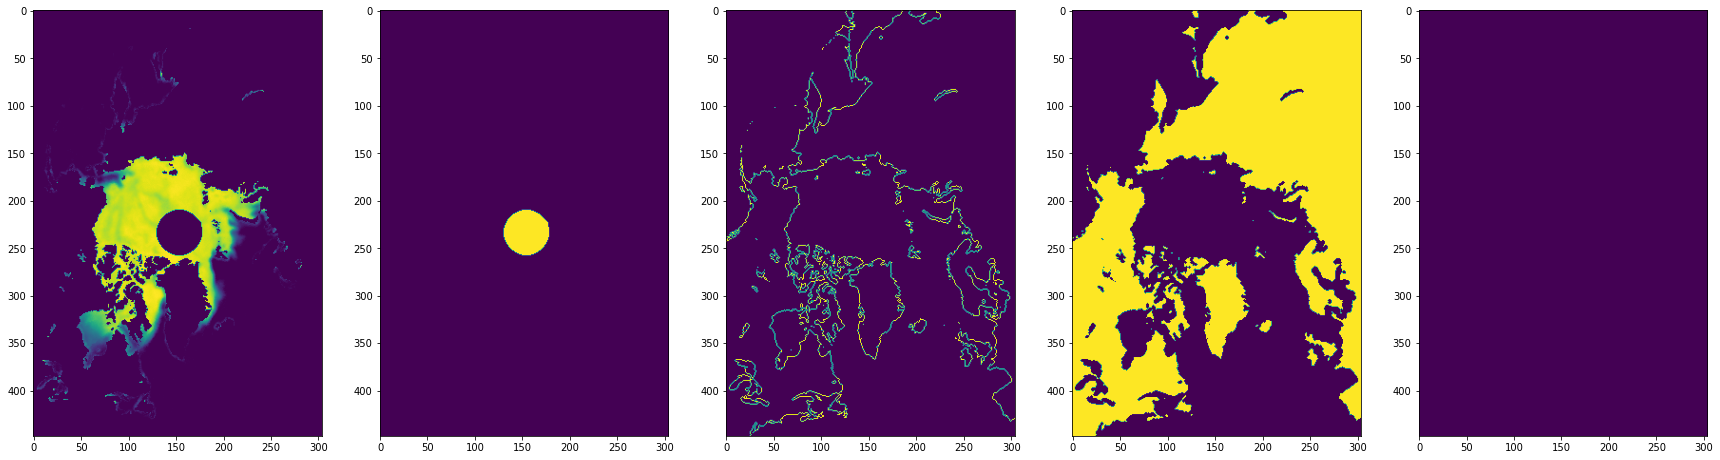

In [22]:
# first image is the image we need to predict for 2019 and 2020
# second image is the size undetected region near the pole
# third and fourth is the shore line, which is same for all dataset
# fifth is the null value which we will ignore
fig = plt.figure(figsize=(30, 15))
for i in range(5):
  fig.add_subplot(1, 5, i+1)
  plt.imshow(data[:, :, i])
fig.show()

In [23]:
fig.savefig('data_images.png')

In [ ]:
# seen annualy, we can see that undetected region is getting smaller,
# And definitely more melted parts
for j in range(0, 482, 12):
  data = np.load(TRAIN_NPY_PATH + train_file_list[j])
  fig = plt.figure(figsize=(20, 50))
  for i in range(5):
    fig.add_subplot(1, 5, i+1)
    plt.imshow(data[:, :, i])
  fig.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# load and combine all data in the one list
all_data = [np.load(TRAIN_NPY_PATH + train_file_list[i]) for i in range(len(train_file_list))]

In [ ]:
# convert to numpy
all_data = np.array(all_data)

In [ ]:
# all data combined
all_data.shape

(482, 448, 304, 5)

In [ ]:
# save for later usage
np.save("all_data.npy", all_data)

In [ ]:
# load
all_data = np.load("../data/all_data.npy")

In [ ]:
all_data.shape

(482, 448, 304, 5)

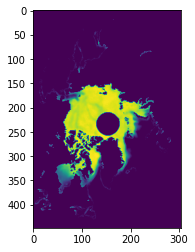

In [ ]:
plt.imshow(all_data[0, :, :, 0])

In [ ]:
all_data[0, :, :, 0]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

For the empty region near the pole, though it won't be counted in the score, I will fill it in with a number representing corresponding dataset

(array([[448.,   0.,   0., ...,   0.,   0.,   0.],
        [448.,   0.,   0., ...,   0.,   0.,   0.],
        [448.,   0.,   0., ...,   0.,   0.,   0.],
        ...,
        [448.,   0.,   0., ...,   0.,   0.,   0.],
        [448.,   0.,   0., ...,   0.,   0.,   0.],
        [448.,   0.,   0., ...,   0.,   0.,   0.]]),
 array([  0.,  25.,  50.,  75., 100., 125., 150., 175., 200., 225., 250.]),
 <a list of 304 Lists of Patches objects>)

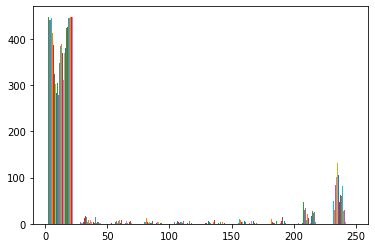

In [ ]:
# looks like 0 is the majority, which is expected
# so instead of mean, i will fill the whole it with median
plt.hist(all_data[0, :, :, 0])

In [ ]:
x = all_data[0, :, :, 0]
np.median(x[x != 0])

221.0

In [ ]:
# fill the whole with median value
data_ice_filled = []

for i in range(all_data.shape[0]):
  data_ice = all_data[i, :, :, 0] # ice data
  data_pole = all_data[i, :, :, 1] # where ice is not detected

  # calculate median value
  ice_median = np.median(data_ice[data_ice != 0]) 
  data_hole = np.where(data_pole != 0, ice_median, 0)
  data_filled = data_ice + data_hole

  ####print(data_hole.shape)
  data_ice_filled += [data_filled]

data_ice_filled = np.array(data_ice_filled)

In [ ]:
# only extracted the ice image
data_ice_filled.shape

(482, 448, 304)

In [ ]:
# save
np.save("data_iced_filled.npy", data_ice_filled)

In [ ]:
# load
data_ice_filled = np.load("../data/data_iced_filled.npy")

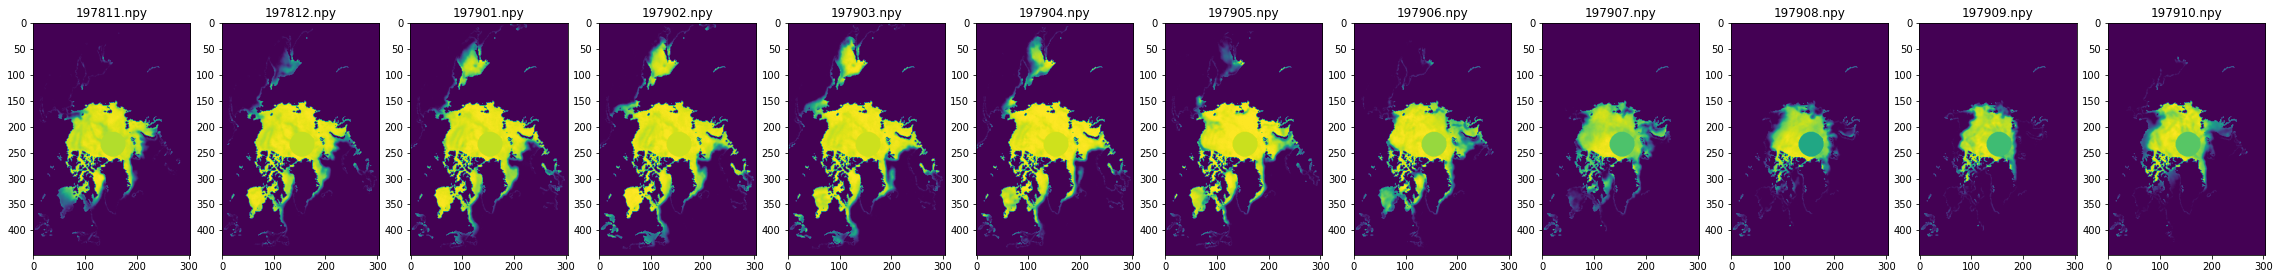

In [ ]:
# plot a few data
## doesnt look that bad
## looks a bit crooked on dataset with more melted region
fig = plt.figure(figsize=(40, 20))
for i in range(12):
  fig.add_subplot(1, 12, i+1)
  plt.imshow(data_ice_filled[i, :, :]/ 250)
  plt.title(train_file_list[i])
fig.show()

### Prepare dataset for Autoencoder

In [ ]:
# make a copy of data and shuffle
dataset = data_ice_filled.copy()
np.random.shuffle(dataset)

In [ ]:
# data length and shape of dataset
print(len(dataset))
print(dataset.shape)

482
(482, 448, 304)


In [ ]:
# since the image has interval of 0 ~ 250. divide by 250 to scale
# we will use 442 data as Train, and 30 as Valid. 10 : 1 ratio approx
X_train, X_valid = dataset[:-40]/250, dataset[-40:]/250

In [ ]:
X_train.shape

(442, 448, 304)

## Find Autoencoder model

Try over variation of model to find the best model
1. model with one Conv2D layer (Conv with filter 16)
2. model with two Conv2D layers (Conv with filter 16 & 32)
3. model #2 with dense layer weights locked for encoder and decoder
4. model with two Conv2D layers with smalller filters (Conv with filter 8 & 16)
5. model with three conv2d layers (Conv with filter 16 & 32 & 64)

Choose the model based on mse value, and play around with learning rate and momentum value to find best parameters


### Model with one Conv2D layer

In [ ]:
import tensorflow as tf
from tensorflow import keras

In [ ]:
encoder = keras.models.Sequential([
    keras.layers.Reshape([448, 304, 1], input_shape=[448, 304]),
    keras.layers.Conv2D(16, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation="sigmoid")
])

encoder.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 448, 304, 1)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 448, 304, 16)      160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 224, 152, 16)      0         
_________________________________________________________________
flatten (Flatten)            (None, 544768)            0         
_________________________________________________________________
dense (Dense)                (None, 128)               69730432  
Total params: 69,730,592
Trainable params: 69,730,592
Non-trainable params: 0
_________________________________________________________________


In [ ]:
decoder = keras.models.Sequential([
    keras.layers.Dense(units=544768, activation="selu", input_shape=[128,]),
    keras.layers.Reshape([224, 152, 16]),
    keras.layers.Conv2DTranspose(1, kernel_size=3, strides=2, padding="SAME", activation="sigmoid"),
    keras.layers.Reshape([448, 304])
])

decoder.summary

<bound method Model.summary of <tensorflow.python.keras.engine.sequential.Sequential object at 0x7f21b9992490>>

In [ ]:
full_ae = keras.models.Sequential([encoder, decoder])

full_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(lr=0.1),
                metrics=["mse"])
history = full_ae.fit(X_train, X_train, epochs=100, batch_size = 8, shuffle=True, validation_data=(X_valid, X_valid))

Epoch 1/100
56/56 [==============================] - 35s 41ms/step - loss: 0.5675 - mse: 0.1737 - val_loss: 0.3901 - val_mse: 0.0954
Epoch 2/100
56/56 [==============================] - 2s 33ms/step - loss: 0.3882 - mse: 0.0955 - val_loss: 0.3532 - val_mse: 0.0837
Epoch 3/100
56/56 [==============================] - 2s 33ms/step - loss: 0.3629 - mse: 0.0876 - val_loss: 0.3448 - val_mse: 0.0815
Epoch 4/100
56/56 [==============================] - 2s 33ms/step - loss: 0.3541 - mse: 0.0851 - val_loss: 0.3424 - val_mse: 0.0810
Epoch 5/100
56/56 [==============================] - 2s 33ms/step - loss: 0.3537 - mse: 0.0850 - val_loss: 0.3413 - val_mse: 0.0808
Epoch 6/100
56/56 [==============================] - 2s 33ms/step - loss: 0.3528 - mse: 0.0848 - val_loss: 0.3407 - val_mse: 0.0807
Epoch 7/100
56/56 [==============================] - 2s 33ms/step - loss: 0.3525 - mse: 0.0849 - val_loss: 0.3404 - val_mse: 0.0806
Epoch 8/100
56/56 [==============================] - 2s 33ms/step - loss: 0

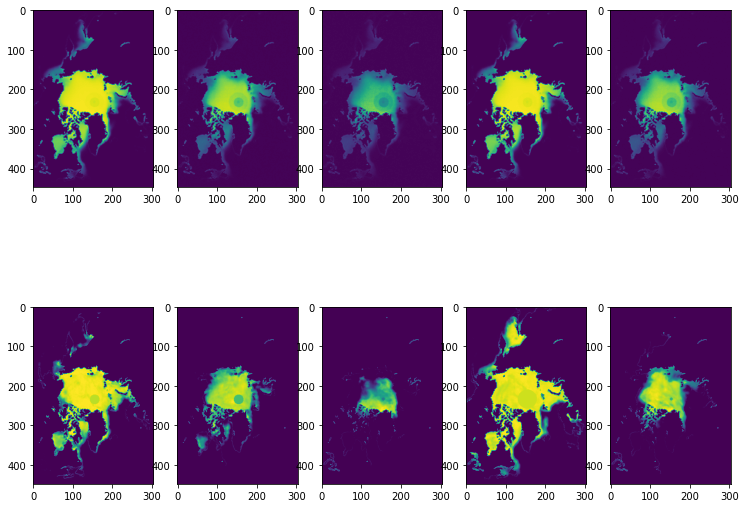

In [ ]:
reconstructions = full_ae.predict(X_valid[:5])
fig = plt.figure(figsize=( 5 * 2.5, 10))
for i in range(5):
  fig.add_subplot(2, 5, i+1)
  plt.imshow(reconstructions[i])

for i in range(5):
  fig.add_subplot(2, 5, i+6)
  plt.imshow(X_valid[:5][i])
fig.show()


In [ ]:
full_ae.save("full_ae_model.h5")
encoder.save("encoder.h5")
decoder.save("decoder.h5")

#### With more layer

In [ ]:
encoder = keras.models.Sequential([
    keras.layers.Reshape([448, 304, 1], input_shape=[448, 304]),
    keras.layers.Conv2D(16, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(32, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Flatten(),
    keras.layers.Dense(256, activation="sigmoid")
])

encoder.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_3 (Reshape)          (None, 448, 304, 1)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 448, 304, 16)      160       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 224, 152, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 224, 152, 32)      4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 112, 76, 32)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 272384)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)              

In [ ]:
encoder.layers[-1].output_shape[1:]

(256,)

In [ ]:
decoder = keras.models.Sequential([
    keras.layers.Dense(units=np.prod(encoder.layers[-3].output_shape[1:]), activation="selu", input_shape=encoder.layers[-1].output_shape[1:]),
    keras.layers.Reshape(encoder.layers[-3].output_shape[1:]),
    keras.layers.Conv2DTranspose(16, kernel_size=3, strides=2, padding="SAME", activation="selu"),
    keras.layers.Conv2DTranspose(1, kernel_size=3, strides=2, padding="SAME", activation="sigmoid"),
    keras.layers.Reshape([448, 304])
])

decoder.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 272384)            70002688  
_________________________________________________________________
reshape_6 (Reshape)          (None, 112, 76, 32)       0         
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 224, 152, 16)      4624      
_________________________________________________________________
conv2d_transpose_4 (Conv2DTr (None, 448, 304, 1)       145       
_________________________________________________________________
reshape_7 (Reshape)          (None, 448, 304)          0         
Total params: 70,007,457
Trainable params: 70,007,457
Non-trainable params: 0
_________________________________________________________________


In [ ]:
full_ae = keras.models.Sequential([encoder, decoder])

full_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(lr=1.0),
                metrics=["mse"])
history = full_ae.fit(X_train, X_train, epochs=100, batch_size = 8, shuffle=True, validation_data=(X_valid, X_valid))

Epoch 1/100
56/56 [==============================] - 3s 46ms/step - loss: 0.4011 - mse: 0.1041 - val_loss: 0.3291 - val_mse: 0.0780
Epoch 2/100
56/56 [==============================] - 2s 41ms/step - loss: 0.2810 - mse: 0.0655 - val_loss: 0.1181 - val_mse: 0.0188
Epoch 3/100
56/56 [==============================] - 2s 41ms/step - loss: 0.1091 - mse: 0.0160 - val_loss: 0.0886 - val_mse: 0.0103
Epoch 4/100
56/56 [==============================] - 2s 41ms/step - loss: 0.0874 - mse: 0.0098 - val_loss: 0.0806 - val_mse: 0.0085
Epoch 5/100
56/56 [==============================] - 2s 41ms/step - loss: 0.0809 - mse: 0.0081 - val_loss: 0.0760 - val_mse: 0.0072
Epoch 6/100
56/56 [==============================] - 2s 41ms/step - loss: 0.0780 - mse: 0.0072 - val_loss: 0.0737 - val_mse: 0.0066
Epoch 7/100
56/56 [==============================] - 2s 41ms/step - loss: 0.0746 - mse: 0.0066 - val_loss: 0.0730 - val_mse: 0.0065
Epoch 8/100
56/56 [==============================] - 2s 41ms/step - loss: 0.

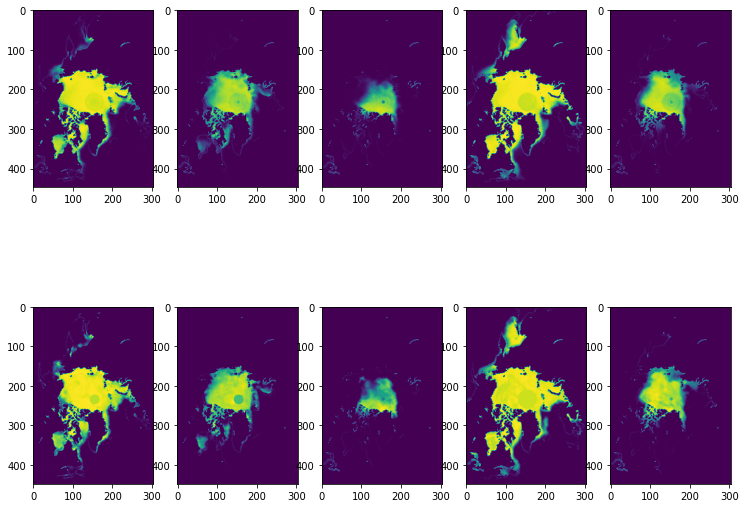

In [ ]:
reconstructions = full_ae.predict(X_valid[:5])
fig = plt.figure(figsize=( 5 * 2.5, 10))
for i in range(5):
  fig.add_subplot(2, 5, i+1)
  plt.imshow(reconstructions[i])

for i in range(5):
  fig.add_subplot(2, 5, i+6)
  plt.imshow(X_valid[:5][i])
fig.show()

### With DenseTranspoe, weights locked for Dense

In [ ]:
class DenseTranspose(keras.layers.Layer):
  def __init__(self, dense, activation=None, **kwargs):
    self.dense = dense
    self.activation = keras.activations.get(activation)
    super().__init__(**kwargs)
  def build(self, batch_input_shape):
    self.biases = self.add_weight(name="bias", initializer="zeros", shape=[self.dense.input_shape[-1]])
    super().build(batch_input_shape)
  def call(self, inputs):
    z = tf.matmul(inputs, self.dense.weights[0], transpose_b=True)
    return self.activation(z + self.biases)

In [ ]:
dense = keras.layers.Dense(256, activation="sigmoid")

encoder = keras.models.Sequential([
    keras.layers.Reshape([448, 304, 1], input_shape=[448, 304]),
    keras.layers.Conv2D(16, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(32, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Flatten(),
    dense
])

encoder.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_8 (Reshape)          (None, 448, 304, 1)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 448, 304, 16)      160       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 224, 152, 16)      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 224, 152, 32)      4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 112, 76, 32)       0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 272384)            0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)              

In [ ]:
decoder = keras.models.Sequential([
    DenseTranspose(dense, activation="selu"),
    keras.layers.Reshape(encoder.layers[-3].output_shape[1:]),
    keras.layers.Conv2DTranspose(16, kernel_size=3, strides=2, padding="SAME", activation="selu"),
    keras.layers.Conv2DTranspose(1, kernel_size=3, strides=2, padding="SAME", activation="sigmoid"),
    keras.layers.Reshape([448, 304])
])

In [ ]:
full_ae = keras.models.Sequential([encoder, decoder])

full_ae.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_7 (Sequential)    (None, 256)               69735360  
_________________________________________________________________
sequential_8 (Sequential)    (None, 448, 304)          70007713  
Total params: 70,012,513
Trainable params: 70,012,513
Non-trainable params: 0
_________________________________________________________________


In [ ]:
full_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(lr=1.0),
                metrics=["mse"])
history = full_ae.fit(X_train, X_train, epochs=100, batch_size = 8, shuffle=True, validation_data=(X_valid, X_valid))

Epoch 1/100
56/56 [==============================] - 3s 45ms/step - loss: 0.4153 - mse: 0.1100 - val_loss: 0.3022 - val_mse: 0.0717
Epoch 2/100
56/56 [==============================] - 2s 41ms/step - loss: 0.2302 - mse: 0.0513 - val_loss: 0.1225 - val_mse: 0.0211
Epoch 3/100
56/56 [==============================] - 2s 41ms/step - loss: 0.1272 - mse: 0.0223 - val_loss: 0.1085 - val_mse: 0.0181
Epoch 4/100
56/56 [==============================] - 2s 41ms/step - loss: 0.1147 - mse: 0.0200 - val_loss: 0.1052 - val_mse: 0.0176
Epoch 5/100
56/56 [==============================] - 2s 41ms/step - loss: 0.1121 - mse: 0.0196 - val_loss: 0.1039 - val_mse: 0.0172
Epoch 6/100
56/56 [==============================] - 2s 41ms/step - loss: 0.1097 - mse: 0.0189 - val_loss: 0.1030 - val_mse: 0.0170
Epoch 7/100
56/56 [==============================] - 2s 41ms/step - loss: 0.1055 - mse: 0.0163 - val_loss: 0.0774 - val_mse: 0.0076
Epoch 8/100
56/56 [==============================] - 2s 41ms/step - loss: 0.

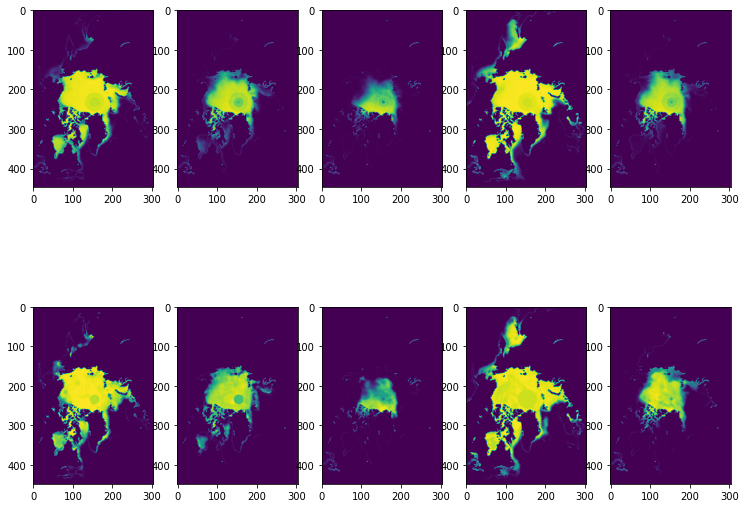

In [ ]:
reconstructions = full_ae.predict(X_valid[:5])
fig = plt.figure(figsize=( 5 * 2.5, 10))
for i in range(5):
  fig.add_subplot(2, 5, i+1)
  plt.imshow(reconstructions[i])

for i in range(5):
  fig.add_subplot(2, 5, i+6)
  plt.imshow(X_valid[:5][i])
fig.show()

### With fewer filters to start with

In [ ]:
encoder = keras.models.Sequential([
    keras.layers.Reshape([448, 304, 1], input_shape=[448, 304]),
    keras.layers.Conv2D(8, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(16, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Flatten(),
    keras.layers.Dense(256, activation="sigmoid")
])

encoder.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_11 (Reshape)         (None, 448, 304, 1)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 448, 304, 8)       80        
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 224, 152, 8)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 224, 152, 16)      1168      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 112, 76, 16)       0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 136192)            0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)             

In [ ]:
decoder = keras.models.Sequential([
    keras.layers.Dense(units=np.prod(encoder.layers[-3].output_shape[1:]), activation="selu", input_shape=encoder.layers[-1].output_shape[1:]),
    keras.layers.Reshape(encoder.layers[-3].output_shape[1:]),
    keras.layers.Conv2DTranspose(8, kernel_size=3, strides=2, padding="SAME", activation="selu"),
    keras.layers.Conv2DTranspose(1, kernel_size=3, strides=2, padding="SAME", activation="sigmoid"),
    keras.layers.Reshape([448, 304])
])

decoder.summary

<bound method Model.summary of <tensorflow.python.keras.engine.sequential.Sequential object at 0x7f216c2dab50>>

In [ ]:
full_ae = keras.models.Sequential([encoder, decoder])

full_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(lr=1.0),
                metrics=["mse"])
history = full_ae.fit(X_train, X_train, epochs=100, batch_size = 8, shuffle=True, validation_data=(X_valid, X_valid))

Epoch 1/100
56/56 [==============================] - 3s 31ms/step - loss: 0.4035 - mse: 0.1058 - val_loss: 0.2659 - val_mse: 0.0600
Epoch 2/100
56/56 [==============================] - 1s 25ms/step - loss: 0.1996 - mse: 0.0413 - val_loss: 0.1026 - val_mse: 0.0134
Epoch 3/100
56/56 [==============================] - 1s 25ms/step - loss: 0.1006 - mse: 0.0129 - val_loss: 0.0869 - val_mse: 0.0103
Epoch 4/100
56/56 [==============================] - 1s 25ms/step - loss: 0.0846 - mse: 0.0090 - val_loss: 0.0783 - val_mse: 0.0076
Epoch 5/100
56/56 [==============================] - 1s 25ms/step - loss: 0.0793 - mse: 0.0076 - val_loss: 0.0757 - val_mse: 0.0071
Epoch 6/100
56/56 [==============================] - 1s 25ms/step - loss: 0.0765 - mse: 0.0070 - val_loss: 0.0739 - val_mse: 0.0066
Epoch 7/100
56/56 [==============================] - 1s 25ms/step - loss: 0.0744 - mse: 0.0067 - val_loss: 0.0726 - val_mse: 0.0064
Epoch 8/100
56/56 [==============================] - 1s 25ms/step - loss: 0.

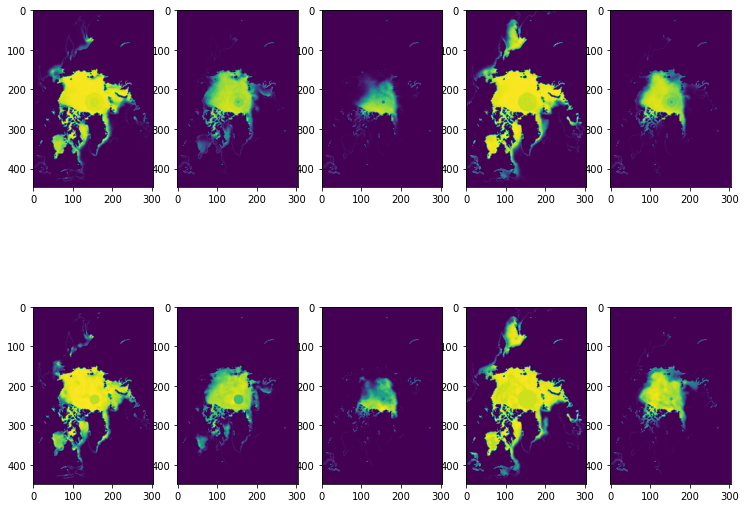

In [ ]:
reconstructions = full_ae.predict(X_valid[:5])
fig = plt.figure(figsize=( 5 * 2.5, 10))
for i in range(5):
  fig.add_subplot(2, 5, i+1)
  plt.imshow(reconstructions[i])

for i in range(5):
  fig.add_subplot(2, 5, i+6)
  plt.imshow(X_valid[:5][i])
fig.show()

### Try with 3 layers

In [ ]:
encoder = keras.models.Sequential([
    keras.layers.Reshape([448, 304, 1], input_shape=[448, 304]),
    keras.layers.Conv2D(16, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(32, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(64, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Flatten(),
    keras.layers.Dense(256, activation="sigmoid")
])

encoder.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_14 (Reshape)         (None, 448, 304, 1)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 448, 304, 16)      160       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 224, 152, 16)      0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 224, 152, 32)      4640      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 112, 76, 32)       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 112, 76, 64)       18496     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 56, 38, 64)      

In [ ]:
decoder = keras.models.Sequential([
    keras.layers.Dense(units=np.prod(encoder.layers[-3].output_shape[1:]), activation="selu", input_shape=encoder.layers[-1].output_shape[1:]),
    keras.layers.Reshape(encoder.layers[-3].output_shape[1:]),
    keras.layers.Conv2DTranspose(32, kernel_size=3, strides=2, padding="SAME", activation="selu"),
    keras.layers.Conv2DTranspose(16, kernel_size=3, strides=2, padding="SAME", activation="selu"),
    keras.layers.Conv2DTranspose(1, kernel_size=3, strides=2, padding="SAME", activation="sigmoid"),
    keras.layers.Reshape([448, 304])
])

decoder.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 136192)            35001344  
_________________________________________________________________
reshape_15 (Reshape)         (None, 56, 38, 64)        0         
_________________________________________________________________
conv2d_transpose_9 (Conv2DTr (None, 112, 76, 32)       18464     
_________________________________________________________________
conv2d_transpose_10 (Conv2DT (None, 224, 152, 16)      4624      
_________________________________________________________________
conv2d_transpose_11 (Conv2DT (None, 448, 304, 1)       145       
_________________________________________________________________
reshape_16 (Reshape)         (None, 448, 304)          0         
Total params: 35,024,577
Trainable params: 35,024,577
Non-trainable params: 0
_________________________________________

In [ ]:
full_ae = keras.models.Sequential([encoder, decoder])

full_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(lr=1.0),
                metrics=["mse"])
history = full_ae.fit(X_train, X_train, epochs=100, batch_size = 8, shuffle=True, validation_data=(X_valid, X_valid))

Epoch 1/100
56/56 [==============================] - 3s 44ms/step - loss: 0.4095 - mse: 0.1079 - val_loss: 0.2953 - val_mse: 0.0705
Epoch 2/100
56/56 [==============================] - 2s 37ms/step - loss: 0.1920 - mse: 0.0401 - val_loss: 0.1020 - val_mse: 0.0146
Epoch 3/100
56/56 [==============================] - 2s 37ms/step - loss: 0.0979 - mse: 0.0134 - val_loss: 0.0832 - val_mse: 0.0093
Epoch 4/100
56/56 [==============================] - 2s 37ms/step - loss: 0.0896 - mse: 0.0112 - val_loss: 0.0799 - val_mse: 0.0086
Epoch 5/100
56/56 [==============================] - 2s 37ms/step - loss: 0.0822 - mse: 0.0089 - val_loss: 0.0782 - val_mse: 0.0082
Epoch 6/100
56/56 [==============================] - 2s 37ms/step - loss: 0.0789 - mse: 0.0082 - val_loss: 0.0779 - val_mse: 0.0083
Epoch 7/100
56/56 [==============================] - 2s 37ms/step - loss: 0.0783 - mse: 0.0080 - val_loss: 0.0768 - val_mse: 0.0079
Epoch 8/100
56/56 [==============================] - 2s 38ms/step - loss: 0.

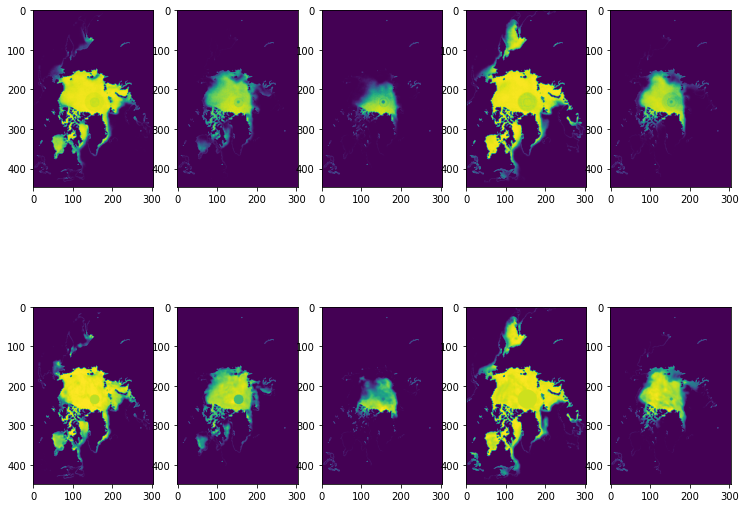

In [ ]:
reconstructions = full_ae.predict(X_valid[:5])
fig = plt.figure(figsize=( 5 * 2.5, 10))
for i in range(5):
  fig.add_subplot(2, 5, i+1)
  plt.imshow(reconstructions[i])

for i in range(5):
  fig.add_subplot(2, 5, i+6)
  plt.imshow(X_valid[:5][i])
fig.show()

### Two layers with 16, 32 seems to work the best

In [ ]:
# with less learning rate

encoder = keras.models.Sequential([
    keras.layers.Reshape([448, 304, 1], input_shape=[448, 304]),
    keras.layers.Conv2D(16, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(32, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Flatten(),
    keras.layers.Dense(256, activation="sigmoid")
])

encoder.summary()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_20 (Reshape)         (None, 448, 304, 1)       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 448, 304, 16)      160       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 224, 152, 16)      0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 224, 152, 32)      4640      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 112, 76, 32)       0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 272384)            0         
_________________________________________________________________
dense_12 (Dense)             (None, 256)             

In [ ]:
decoder = keras.models.Sequential([
    keras.layers.Dense(units=np.prod(encoder.layers[-3].output_shape[1:]), activation="selu", input_shape=encoder.layers[-1].output_shape[1:]),
    keras.layers.Reshape(encoder.layers[-3].output_shape[1:]),
    keras.layers.Conv2DTranspose(16, kernel_size=3, strides=2, padding="SAME", activation="selu"),
    keras.layers.Conv2DTranspose(1, kernel_size=3, strides=2, padding="SAME", activation="sigmoid"),
    keras.layers.Reshape([448, 304])
])

decoder.summary()

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 272384)            70002688  
_________________________________________________________________
reshape_21 (Reshape)         (None, 112, 76, 32)       0         
_________________________________________________________________
conv2d_transpose_14 (Conv2DT (None, 224, 152, 16)      4624      
_________________________________________________________________
conv2d_transpose_15 (Conv2DT (None, 448, 304, 1)       145       
_________________________________________________________________
reshape_22 (Reshape)         (None, 448, 304)          0         
Total params: 70,007,457
Trainable params: 70,007,457
Non-trainable params: 0
_________________________________________________________________


In [ ]:
full_ae = keras.models.Sequential([encoder, decoder])

full_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(lr=0.1),
                metrics=["mse"])
history = full_ae.fit(X_train, X_train, epochs=100, batch_size = 8, shuffle=True, validation_data=(X_valid, X_valid))

Epoch 1/100
56/56 [==============================] - 3s 45ms/step - loss: 0.5452 - mse: 0.1634 - val_loss: 0.3643 - val_mse: 0.0870
Epoch 2/100
56/56 [==============================] - 2s 41ms/step - loss: 0.3650 - mse: 0.0881 - val_loss: 0.3442 - val_mse: 0.0815
Epoch 3/100
56/56 [==============================] - 2s 40ms/step - loss: 0.3574 - mse: 0.0862 - val_loss: 0.3414 - val_mse: 0.0808
Epoch 4/100
56/56 [==============================] - 2s 40ms/step - loss: 0.3578 - mse: 0.0868 - val_loss: 0.3403 - val_mse: 0.0806
Epoch 5/100
56/56 [==============================] - 2s 41ms/step - loss: 0.3618 - mse: 0.0884 - val_loss: 0.3395 - val_mse: 0.0804
Epoch 6/100
56/56 [==============================] - 2s 41ms/step - loss: 0.3437 - mse: 0.0817 - val_loss: 0.3386 - val_mse: 0.0802
Epoch 7/100
56/56 [==============================] - 2s 40ms/step - loss: 0.3536 - mse: 0.0857 - val_loss: 0.3373 - val_mse: 0.0800
Epoch 8/100
56/56 [==============================] - 2s 41ms/step - loss: 0.

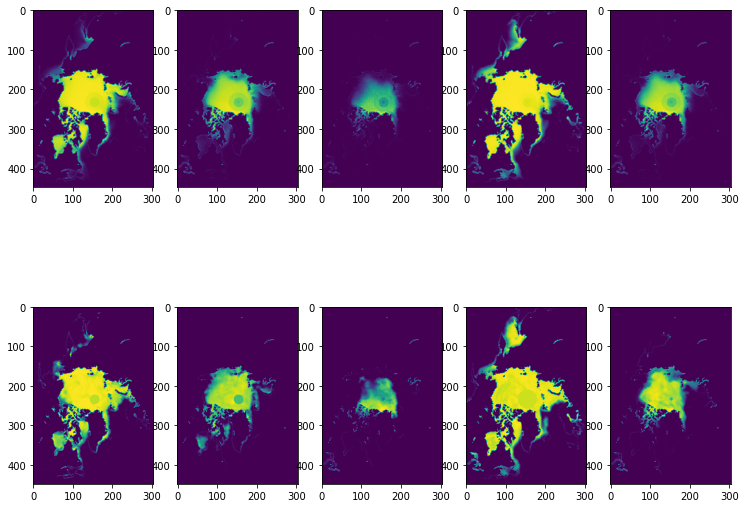

In [ ]:
reconstructions = full_ae.predict(X_valid[:5])
fig = plt.figure(figsize=( 5 * 2.5, 10))
for i in range(5):
  fig.add_subplot(2, 5, i+1)
  plt.imshow(reconstructions[i])

for i in range(5):
  fig.add_subplot(2, 5, i+6)
  plt.imshow(X_valid[:5][i])
fig.show()

#### Train with momentum

In [ ]:
gc.garbage.clear()

In [ ]:
encoder = keras.models.Sequential([
    keras.layers.Reshape([448, 304, 1], input_shape=[448, 304]),
    keras.layers.Conv2D(16, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(32, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Flatten(),
    keras.layers.Dense(256, activation="sigmoid")
])

encoder.summary()

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_24 (Reshape)         (None, 448, 304, 1)       0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 448, 304, 16)      160       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 224, 152, 16)      0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 224, 152, 32)      4640      
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 112, 76, 32)       0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 272384)            0         
_________________________________________________________________
dense_15 (Dense)             (None, 256)             

In [ ]:
decoder = keras.models.Sequential([
    keras.layers.Dense(units=np.prod(encoder.layers[-3].output_shape[1:]), activation="selu", input_shape=encoder.layers[-1].output_shape[1:]),
    keras.layers.Reshape(encoder.layers[-3].output_shape[1:]),
    keras.layers.Conv2DTranspose(16, kernel_size=3, strides=2, padding="SAME", activation="selu"),
    keras.layers.Conv2DTranspose(1, kernel_size=3, strides=2, padding="SAME", activation="sigmoid"),
    keras.layers.Reshape([448, 304])
])

decoder.summary()

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 272384)            70002688  
_________________________________________________________________
reshape_25 (Reshape)         (None, 112, 76, 32)       0         
_________________________________________________________________
conv2d_transpose_16 (Conv2DT (None, 224, 152, 16)      4624      
_________________________________________________________________
conv2d_transpose_17 (Conv2DT (None, 448, 304, 1)       145       
_________________________________________________________________
reshape_26 (Reshape)         (None, 448, 304)          0         
Total params: 70,007,457
Trainable params: 70,007,457
Non-trainable params: 0
_________________________________________________________________


In [ ]:
full_ae = keras.models.Sequential([encoder, decoder])

full_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(lr=0.1, momentum=0.9),
                metrics=["mse"])
history = full_ae.fit(X_train, X_train, epochs=200, batch_size = 8, shuffle=True, validation_data=(X_valid, X_valid))

Epoch 1/200
56/56 [==============================] - 3s 52ms/step - loss: 0.4637 - mse: 0.1294 - val_loss: 0.3406 - val_mse: 0.0806
Epoch 2/200
56/56 [==============================] - 3s 48ms/step - loss: 0.3559 - mse: 0.0860 - val_loss: 0.3372 - val_mse: 0.0800
Epoch 3/200
56/56 [==============================] - 3s 48ms/step - loss: 0.3463 - mse: 0.0841 - val_loss: 0.2124 - val_mse: 0.0438
Epoch 4/200
56/56 [==============================] - 3s 48ms/step - loss: 0.1652 - mse: 0.0310 - val_loss: 0.1035 - val_mse: 0.0154
Epoch 5/200
56/56 [==============================] - 3s 48ms/step - loss: 0.1000 - mse: 0.0138 - val_loss: 0.0853 - val_mse: 0.0096
Epoch 6/200
56/56 [==============================] - 3s 48ms/step - loss: 0.0856 - mse: 0.0093 - val_loss: 0.0783 - val_mse: 0.0078
Epoch 7/200
56/56 [==============================] - 3s 48ms/step - loss: 0.0792 - mse: 0.0078 - val_loss: 0.0750 - val_mse: 0.0069
Epoch 8/200
56/56 [==============================] - 3s 48ms/step - loss: 0.

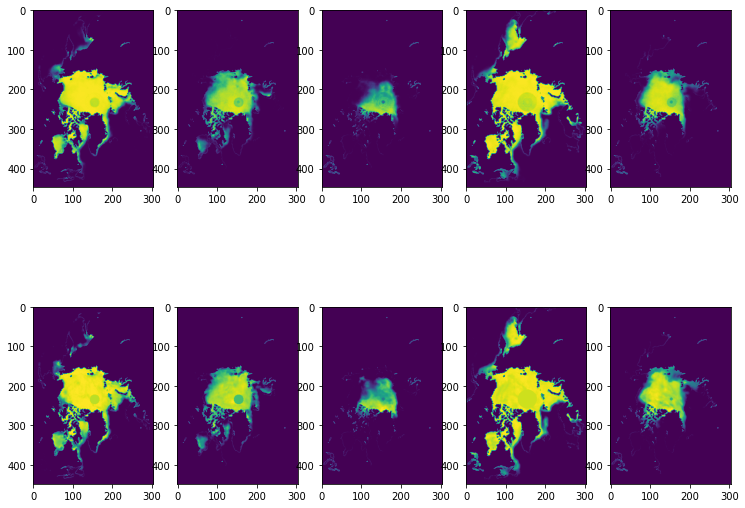

In [ ]:
reconstructions = full_ae.predict(X_valid[:5])
fig = plt.figure(figsize=( 5 * 2.5, 10))
for i in range(5):
  fig.add_subplot(2, 5, i+1)
  plt.imshow(reconstructions[i])

for i in range(5):
  fig.add_subplot(2, 5, i+6)
  plt.imshow(X_valid[:5][i])
fig.show()

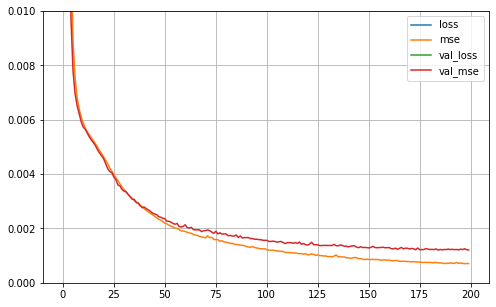

In [ ]:
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0, 0.01)
plt.show()

#### one last one with lr = 0.01 and momentum = 0.99

In [ ]:
gc.garbage.clear()

In [ ]:
encoder = keras.models.Sequential([
    keras.layers.Reshape([448, 304, 1], input_shape=[448, 304]),
    keras.layers.Conv2D(16, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(32, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Flatten(),
    keras.layers.Dense(256, activation="sigmoid")
])

encoder.summary()

Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_30 (Reshape)         (None, 448, 304, 1)       0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 448, 304, 16)      160       
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 224, 152, 16)      0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 224, 152, 32)      4640      
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 112, 76, 32)       0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 272384)            0         
_________________________________________________________________
dense_19 (Dense)             (None, 256)             

In [ ]:
decoder = keras.models.Sequential([
    keras.layers.Dense(units=np.prod(encoder.layers[-3].output_shape[1:]), activation="selu", input_shape=encoder.layers[-1].output_shape[1:]),
    keras.layers.Reshape(encoder.layers[-3].output_shape[1:]),
    keras.layers.Conv2DTranspose(16, kernel_size=3, strides=2, padding="SAME", activation="selu"),
    keras.layers.Conv2DTranspose(1, kernel_size=3, strides=2, padding="SAME", activation="sigmoid"),
    keras.layers.Reshape([448, 304])
])

decoder.summary()

Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_20 (Dense)             (None, 272384)            70002688  
_________________________________________________________________
reshape_31 (Reshape)         (None, 112, 76, 32)       0         
_________________________________________________________________
conv2d_transpose_20 (Conv2DT (None, 224, 152, 16)      4624      
_________________________________________________________________
conv2d_transpose_21 (Conv2DT (None, 448, 304, 1)       145       
_________________________________________________________________
reshape_32 (Reshape)         (None, 448, 304)          0         
Total params: 70,007,457
Trainable params: 70,007,457
Non-trainable params: 0
_________________________________________________________________


In [ ]:
full_ae = keras.models.Sequential([encoder, decoder])

full_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(lr=0.01, momentum=0.99),
                metrics=["mse"])
history = full_ae.fit(X_train, X_train, epochs=200, batch_size = 8, shuffle=True, validation_data=(X_valid, X_valid))

Epoch 1/200
56/56 [==============================] - 3s 51ms/step - loss: 0.5656 - mse: 0.1749 - val_loss: 0.3909 - val_mse: 0.0858
Epoch 2/200
56/56 [==============================] - 3s 47ms/step - loss: 0.4424 - mse: 0.0944 - val_loss: 0.3706 - val_mse: 0.0840
Epoch 3/200
56/56 [==============================] - 3s 47ms/step - loss: 0.3810 - mse: 0.0909 - val_loss: 0.3484 - val_mse: 0.0822
Epoch 4/200
56/56 [==============================] - 3s 47ms/step - loss: 0.3661 - mse: 0.0867 - val_loss: 0.3425 - val_mse: 0.0809
Epoch 5/200
56/56 [==============================] - 3s 48ms/step - loss: 0.3546 - mse: 0.0853 - val_loss: 0.3340 - val_mse: 0.0794
Epoch 6/200
56/56 [==============================] - 3s 48ms/step - loss: 0.3405 - mse: 0.0827 - val_loss: 0.2408 - val_mse: 0.0503
Epoch 7/200
56/56 [==============================] - 3s 48ms/step - loss: 0.1984 - mse: 0.0390 - val_loss: 0.1383 - val_mse: 0.0243
Epoch 8/200
56/56 [==============================] - 3s 48ms/step - loss: 0.

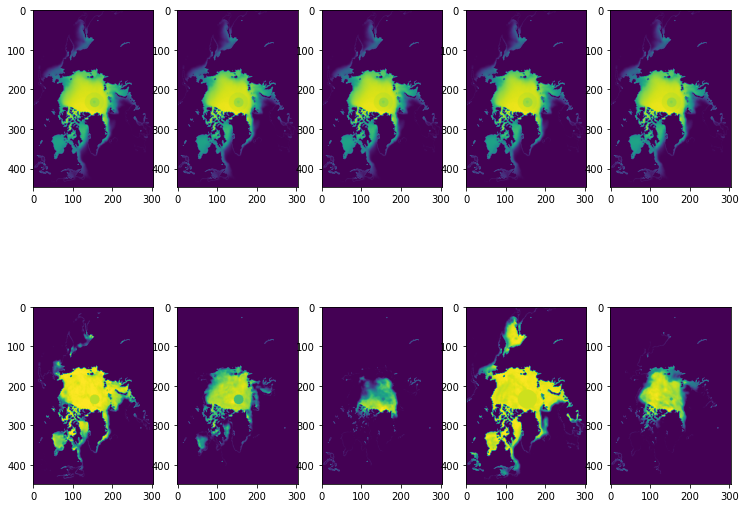

In [ ]:
reconstructions = full_ae.predict(X_valid[:5])
fig = plt.figure(figsize=( 5 * 2.5, 10))
for i in range(5):
  fig.add_subplot(2, 5, i+1)
  plt.imshow(reconstructions[i])

for i in range(5):
  fig.add_subplot(2, 5, i+6)
  plt.imshow(X_valid[:5][i])
fig.show()

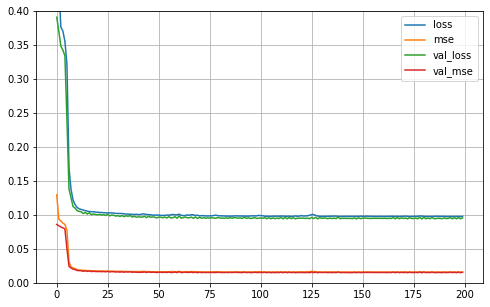

In [ ]:
# model seems to be lost....
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0, 0.4)
plt.show()

#### with 1000 epochs, lr = 0.1, momentum = 0.9

In [ ]:
gc.garbage.clear()

In [ ]:
encoder = keras.models.Sequential([
    keras.layers.Reshape([448, 304, 1], input_shape=[448, 304]),
    keras.layers.Conv2D(16, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(32, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Flatten(),
    keras.layers.Dense(256, activation="sigmoid")
])

encoder.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_12 (Reshape)         (None, 448, 304, 1)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 448, 304, 16)      160       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 224, 152, 16)      0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 224, 152, 32)      4640      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 112, 76, 32)       0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 272384)            0         
_________________________________________________________________
dense_8 (Dense)              (None, 256)             

In [ ]:
decoder = keras.models.Sequential([
    keras.layers.Dense(units=np.prod(encoder.layers[-3].output_shape[1:]), activation="selu", input_shape=encoder.layers[-1].output_shape[1:]),
    keras.layers.Reshape(encoder.layers[-3].output_shape[1:]),
    keras.layers.Conv2DTranspose(16, kernel_size=3, strides=2, padding="SAME", activation="selu"),
    keras.layers.Conv2DTranspose(1, kernel_size=3, strides=2, padding="SAME", activation="sigmoid"),
    keras.layers.Reshape([448, 304])
])

decoder.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 272384)            70002688  
_________________________________________________________________
reshape_13 (Reshape)         (None, 112, 76, 32)       0         
_________________________________________________________________
conv2d_transpose_8 (Conv2DTr (None, 224, 152, 16)      4624      
_________________________________________________________________
conv2d_transpose_9 (Conv2DTr (None, 448, 304, 1)       145       
_________________________________________________________________
reshape_14 (Reshape)         (None, 448, 304)          0         
Total params: 70,007,457
Trainable params: 70,007,457
Non-trainable params: 0
_________________________________________________________________


In [ ]:
full_ae = keras.models.Sequential([encoder, decoder])

full_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(lr=0.1, momentum=0.9),
                metrics=["mse"])

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
history = full_ae.fit(X_train, X_train, epochs=700, batch_size = 8, shuffle=True, validation_data=(X_valid, X_valid), 
                      #callbacks=[callback]
                      )

Epoch 1/700
56/56 [==============================] - 3s 51ms/step - loss: 0.4629 - mse: 0.1297 - val_loss: 0.3434 - val_mse: 0.0809
Epoch 2/700
56/56 [==============================] - 3s 48ms/step - loss: 0.3502 - mse: 0.0836 - val_loss: 0.3411 - val_mse: 0.0804
Epoch 3/700
56/56 [==============================] - 3s 47ms/step - loss: 0.3568 - mse: 0.0864 - val_loss: 0.3381 - val_mse: 0.0798
Epoch 4/700
56/56 [==============================] - 3s 47ms/step - loss: 0.3435 - mse: 0.0829 - val_loss: 0.2326 - val_mse: 0.0494
Epoch 5/700
56/56 [==============================] - 3s 47ms/step - loss: 0.1771 - mse: 0.0346 - val_loss: 0.1133 - val_mse: 0.0184
Epoch 6/700
56/56 [==============================] - 3s 47ms/step - loss: 0.1023 - mse: 0.0143 - val_loss: 0.0872 - val_mse: 0.0099
Epoch 7/700
56/56 [==============================] - 3s 47ms/step - loss: 0.0853 - mse: 0.0091 - val_loss: 0.0792 - val_mse: 0.0079
Epoch 8/700
56/56 [==============================] - 3s 47ms/step - loss: 0.

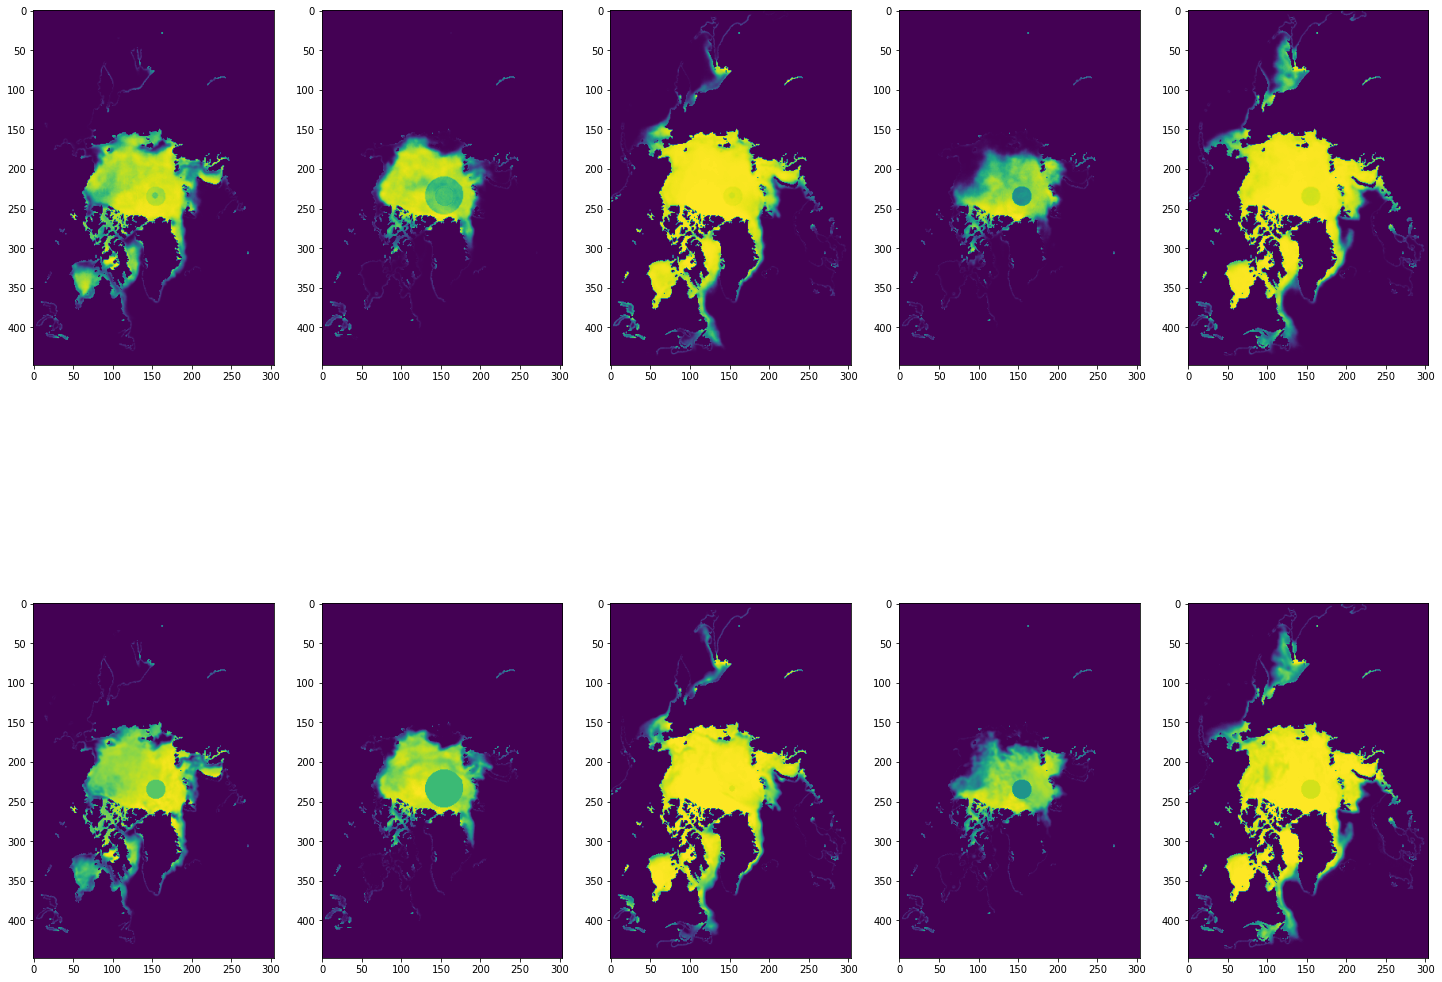

In [ ]:
reconstructions = full_ae.predict(X_valid[10:15])
fig = plt.figure(figsize=( 5 * 5, 20))
for i in range(5):
  fig.add_subplot(2, 5, i+1)
  plt.imshow(reconstructions[i])

for i in range(5):
  fig.add_subplot(2, 5, i+6)
  plt.imshow(X_valid[10:15][i])
fig.show()

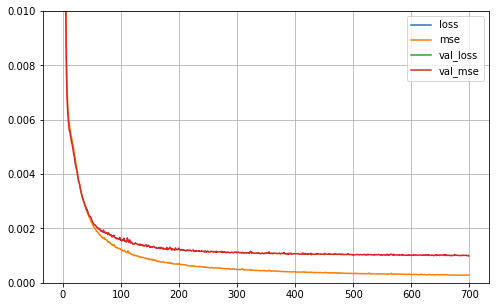

In [ ]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0, 0.01)
plt.show()

In [ ]:
# saved at 700 epochs
full_ae.save("full_ae_model.h5")
encoder.save("encoder.h5")
decoder.save("decoder.h5")

### Using Exponential Decay

In [ ]:
encoder = keras.models.Sequential([
    keras.layers.Reshape([448, 304, 1], input_shape=[448, 304]),
    keras.layers.Conv2D(16, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(32, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Flatten(),
    keras.layers.Dense(256, activation="sigmoid")
])

encoder.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_9 (Reshape)          (None, 448, 304, 1)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 448, 304, 16)      160       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 224, 152, 16)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 224, 152, 32)      4640      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 112, 76, 32)       0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 272384)            0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)             

In [ ]:
decoder = keras.models.Sequential([
    keras.layers.Dense(units=np.prod(encoder.layers[-3].output_shape[1:]), activation="selu", input_shape=encoder.layers[-1].output_shape[1:]),
    keras.layers.Reshape(encoder.layers[-3].output_shape[1:]),
    keras.layers.Conv2DTranspose(16, kernel_size=3, strides=2, padding="SAME", activation="selu"),
    keras.layers.Conv2DTranspose(1, kernel_size=3, strides=2, padding="SAME", activation="sigmoid"),
    keras.layers.Reshape([448, 304])
])

decoder.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 272384)            70002688  
_________________________________________________________________
reshape_10 (Reshape)         (None, 112, 76, 32)       0         
_________________________________________________________________
conv2d_transpose_6 (Conv2DTr (None, 224, 152, 16)      4624      
_________________________________________________________________
conv2d_transpose_7 (Conv2DTr (None, 448, 304, 1)       145       
_________________________________________________________________
reshape_11 (Reshape)         (None, 448, 304)          0         
Total params: 70,007,457
Trainable params: 70,007,457
Non-trainable params: 0
_________________________________________________________________


In [ ]:
def exponential_decay(lr0, w, s):
  def exponential_decay_fn(epoch):
    return lr0 * w**(epoch / s)
  return exponential_decay_fn

exponential_decay_fn = exponential_decay(lr0=0.1, w=0.99, s=10)

In [ ]:
full_ae = keras.models.Sequential([encoder, decoder])

full_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(lr=0.1, momentum=0.9),
                metrics=["mse"])

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
lr_scheduler = keras.callbacks.LearningRateScheduler(exponential_decay_fn)

history = full_ae.fit(X_train, X_train, epochs=500, batch_size = 8, shuffle=True, validation_data=(X_valid, X_valid), 
                      callbacks=[lr_scheduler]
                      )

Epoch 1/500
56/56 [==============================] - 4s 52ms/step - loss: 0.4633 - mse: 0.1298 - val_loss: 0.3421 - val_mse: 0.0807
Epoch 2/500
56/56 [==============================] - 3s 47ms/step - loss: 0.3575 - mse: 0.0867 - val_loss: 0.3408 - val_mse: 0.0804
Epoch 3/500
56/56 [==============================] - 3s 48ms/step - loss: 0.3536 - mse: 0.0854 - val_loss: 0.3377 - val_mse: 0.0798
Epoch 4/500
56/56 [==============================] - 3s 48ms/step - loss: 0.3408 - mse: 0.0820 - val_loss: 0.2414 - val_mse: 0.0519
Epoch 5/500
56/56 [==============================] - 3s 48ms/step - loss: 0.1872 - mse: 0.0379 - val_loss: 0.1159 - val_mse: 0.0198
Epoch 6/500
56/56 [==============================] - 3s 48ms/step - loss: 0.1038 - mse: 0.0151 - val_loss: 0.0899 - val_mse: 0.0110
Epoch 7/500
56/56 [==============================] - 3s 48ms/step - loss: 0.0875 - mse: 0.0099 - val_loss: 0.0800 - val_mse: 0.0082
Epoch 8/500
56/56 [==============================] - 3s 48ms/step - loss: 0.

### Load model with 700 epochs

In [ ]:
full_ae = keras.models.load_model("full_ae_model.h5")
encoder = keras.models.load_model("encoder.h5")
decoder = keras.models.load_model("decoder.h5")

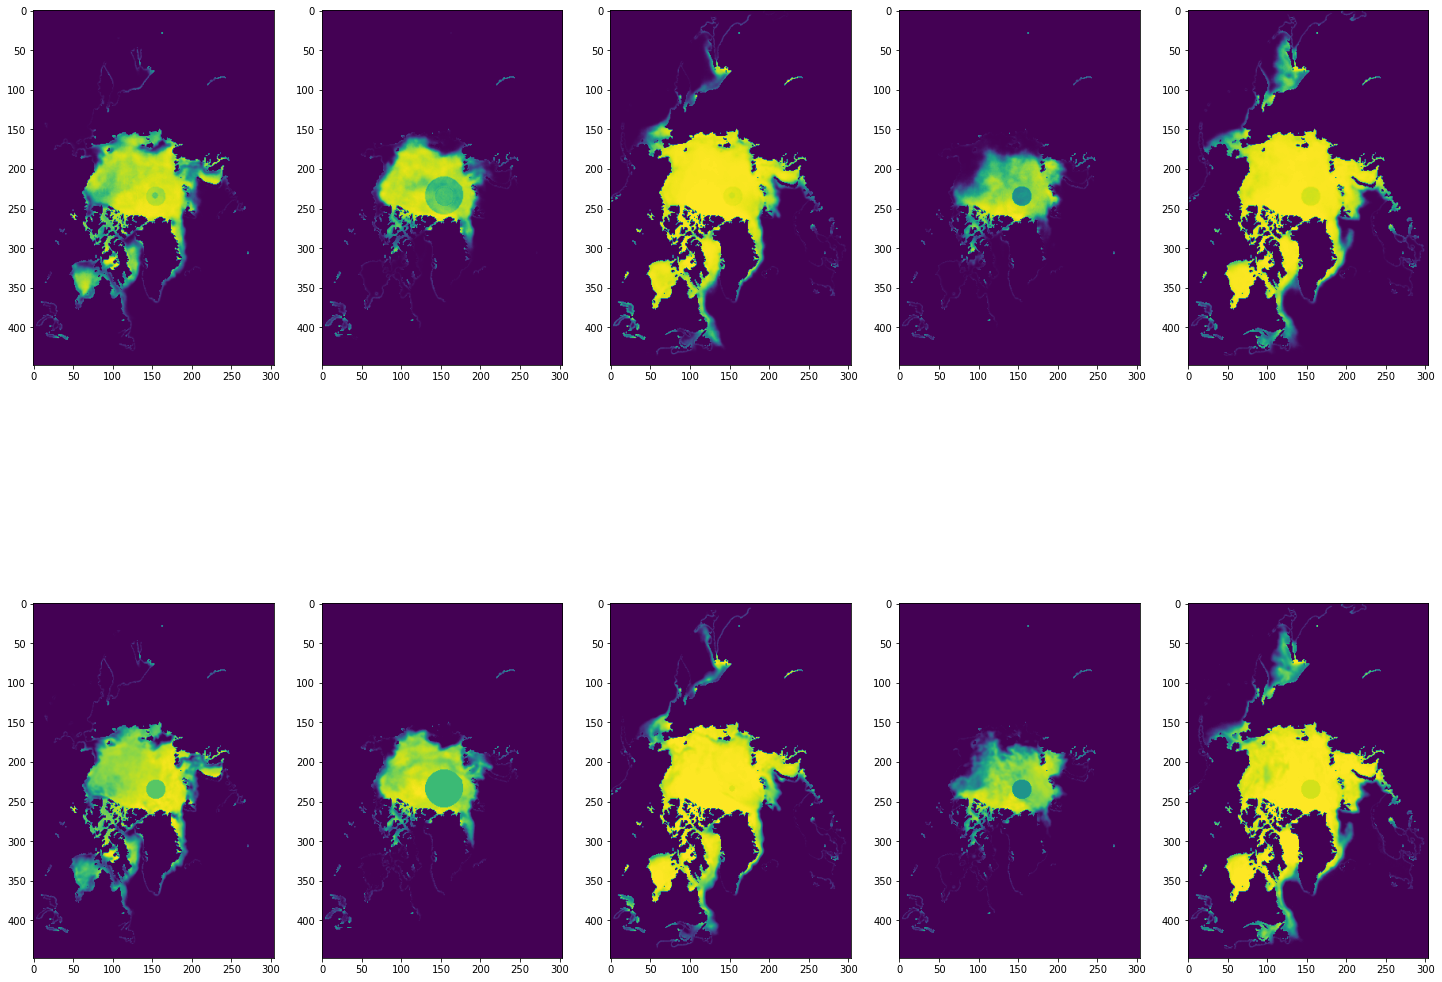

In [ ]:
reconstructions = full_ae.predict(X_valid[10:15])
fig = plt.figure(figsize=( 5 * 5, 20))
for i in range(5):
  fig.add_subplot(2, 5, i+1)
  plt.imshow(reconstructions[i])

for i in range(5):
  fig.add_subplot(2, 5, i+6)
  plt.imshow(X_valid[10:15][i])
fig.show()

In [ ]:
data_ice_filled.shape

(482, 448, 304)

### Encode the dataset

With the encoder chosen at last, encode all the dataset to be used for prediction

In [ ]:
# encode dataset
encoded_dataset = encoder.predict(data_ice_filled)

In [ ]:
encoded_dataset.shape

(482, 256)

In [ ]:
np.save("encoded_dataset.npy", encoded_dataset)